# Stock Prediction RNN 

In this project, I perform a time series prediction using a Recurrent Neural Network regressor. For this example, I will use open and close price to predict open stock price 7 days in advance.

The particular network architecture I will employ for my RNN is a  [Long Term Short Memory (LTSM)](https://en.wikipedia.org/wiki/Long_short-term_memory), which helps significantly avoid technical problems with optimization of RNNs.

# Pytorch LSTM Stock Predictor

This is a Pytorch version of the original Keras LSTM Stock Predictor provided by [Super DataScience](https://www.superdatascience.com/deep-learning/), and also available elsewhere in this repo as a notebook.

## Step 1: Loading the data

First let's load in our time series - a history of around 140 days of Apple's stock price. Then we need to perform a number of pre-processing steps to prepare it for use with an RNN model.  First off, it is good practice to normalize time series - by normalizing its range.  This helps us avoid serious numerical issues associated how common activation functions (like tanh) transform very large (positive or negative) numbers, as well as helping us to avoid related issues when computing derivatives.

Here we normalize the series to lie in the range [0,1] [using this scikit function](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

In [0]:
# download the data
!wget https://raw.githubusercontent.com/tonylaioffer/stock-prediction-lstm-using-keras/master/data/sandp500/all_stocks_5yr.csv

--2020-02-07 22:25:53--  https://raw.githubusercontent.com/tonylaioffer/stock-prediction-lstm-using-keras/master/data/sandp500/all_stocks_5yr.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29580549 (28M) [text/plain]
Saving to: ‘all_stocks_5yr.csv.25’

all_stocks_5yr.csv. 100%[===================>]  28.21M  --.-KB/s    in 0.1s    

2020-02-07 22:25:54 (229 MB/s) - ‘all_stocks_5yr.csv.25’ saved [29580549/29580549]



In [0]:
!ls .

all_stocks_5yr.csv     all_stocks_5yr.csv.17  all_stocks_5yr.csv.25
all_stocks_5yr.csv.1   all_stocks_5yr.csv.18  all_stocks_5yr.csv.3
all_stocks_5yr.csv.10  all_stocks_5yr.csv.19  all_stocks_5yr.csv.4
all_stocks_5yr.csv.11  all_stocks_5yr.csv.2   all_stocks_5yr.csv.5
all_stocks_5yr.csv.12  all_stocks_5yr.csv.20  all_stocks_5yr.csv.6
all_stocks_5yr.csv.13  all_stocks_5yr.csv.21  all_stocks_5yr.csv.7
all_stocks_5yr.csv.14  all_stocks_5yr.csv.22  all_stocks_5yr.csv.8
all_stocks_5yr.csv.15  all_stocks_5yr.csv.23  all_stocks_5yr.csv.9
all_stocks_5yr.csv.16  all_stocks_5yr.csv.24  sample_data


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [0]:
# Importing the training set
dataset = pd.read_csv('./all_stocks_5yr.csv')
data_company = dataset[dataset['Name']=='AAL']

In [0]:
data_company.head(5)

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [0]:
data_input = data_company[['open', 'close']]
data_input = data_input.to_numpy().reshape(-1, 1)

data_target = data_company[['open']]
data_target = data_target.to_numpy()

In [0]:
dataset.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [0]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))

# scale the data
data_input = sc.fit_transform(data_input)
data_target =  sc.transform(data_target)

## Step 2:  Cutting our time series into sequences

Remember, our time series is a sequence of numbers that we can represent in general mathematically as 

$$s_{0},s_{1},s_{2},...,s_{P}$$

where $s_{p}$ is the numerical value of the time series at time period $p$ and where $P$ is the total length of the series.  In order to apply our RNN we treat the time series prediction problem as a regression problem, and so need to use a sliding window to construct a set of associated input/output pairs to regress on.  This process is animated in the gif below.

<img src="https://github.com/tonylaioffer/stock-prediction-lstm-using-keras/raw/master/images/timeseries_windowing_training.gif" width=600 height=288/>

For example - using a window of size T = 5 (as illustrated in the gif above) we produce a set of input/output pairs like the one shown in the table below

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3},s_{4},s_{5}\rangle} & \color{Goldenrod}{ s_{6}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4},s_{5},s_{6} \rangle } & \color{Goldenrod} {s_{7} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-5},s_{P-4},s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$

Notice here that each input is a sequence (or vector) of length 4 (and in general has length equal to the window size T) while each corresponding output is a scalar value.  Notice also how given a time series of length P and window size T = 5 as shown above, we created P - 5  input/output pairs.  More generally, for a window size T we create P - T such pairs.

Now let's window the input time series as described above!  

In [0]:
WINDOW_SIZE = 7 
#Create a function to process the data into 7 day look back slices
def processData(data_input, data_target, lb):
    X, Y = [], []
    for i in range(0, len(data_input) - lb*2, 2):  #open + close
        X.append(data_input[i: (i + lb*2), 0])

    for i in range(len(data_target) - lb):
        Y.append(data_target[(i + lb), 0])

    return np.array(X), np.array(Y)
X, y = processData(data_input, data_target, WINDOW_SIZE)

In [0]:
X.shape

(1252, 14)

In [0]:
y.shape

(1252,)

## Step 3: Split training and testing sets

In order to perform proper testing on our dataset we will lop off the last 20% of it for validation (or testing).  

Note how here we are **not** splitting the dataset *randomly* as one typically would do when validating a regression model.  This is because our input/output pairs *are related temporally*.   We don't want to validate our model by training on a random subset of the series and then testing on another random subset, as this simulates the scenario that we receive new points *within the timeframe of our training set*.  

We want to train on one solid chunk of the series (in our case, the first full 80% of it), and validate on a later chunk (the last 20%) as this simulates how we would predict *future* values of a time series.

In [0]:
X_train, X_test = X[:int(X.shape[0]*0.80)],X[int(X.shape[0]*0.80):]
y_train, y_test = y[:int(y.shape[0]*0.80)],y[int(y.shape[0]*0.80):]
print(X_train.shape)
print(X_test.shape)

# reshaping
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape)
print(X_test.shape)

(1001, 14)
(251, 14)
(1001, 1, 14)
(251, 1, 14)


## Step 4:  Build and run an LSTM regression model

Having created input/output pairs out of our time series and cut this into training/testing sets, we can now begin setting up our LSTM. Here uses PyTorch to quickly build a two hidden layer LSTM of the following specifications

- layer 1 uses an LSTM module with 5 hidden units (note here the input_shape = (window_size,1))
- layer 2 uses a fully connected module with one unit
- the 'mean_squared_error' loss should be used

In [0]:
class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(
            input_size=i_size,
            hidden_size=h_size,
            num_layers=n_layers
        )
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)
        
        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, hidden_size)
        outs = self.out(r_out)

        return outs, hidden_state

In [0]:
# Globals variables

INPUT_SIZE = 7 * 2  #open + close
HIDDEN_SIZE = 64
NUM_LAYERS = 1
OUTPUT_SIZE = 1
BATCH_SIZE = 128

# Hyper parameters
learning_rate = 0.001
num_epochs = 100

rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)
rnn.cuda()

optimiser = optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

hidden_state = None
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', patience=3, threshold = 0.0001, factor = 0.1)

In [0]:
rnn

RNN(
  (rnn): LSTM(14, 64)
  (out): Linear(in_features=64, out_features=1, bias=True)
)

In [0]:
history = []

#Transform numpy array to torch tensor
X_test_cuda = torch.tensor(X_test).float().cuda()
y_test_cuda = torch.tensor(y_test).float().cuda()

# we use all the data in one batch
inputs_cuda = torch.tensor(X_train).float().cuda()
labels_cuda = torch.tensor(y_train).float().cuda()

for epoch in range(num_epochs):
    rnn.train()
    output, hidden_state = rnn(inputs_cuda, hidden_state) 

    loss = criterion(output.view(-1), labels_cuda)
    optimiser.zero_grad()
    loss.backward(retain_graph=True)                     # back propagation
    optimiser.step()                                     # update the parameters
    
    if epoch % 10 == 0:
        rnn.eval()
        test_output, _ = rnn(X_test_cuda, hidden_state)
        test_loss = criterion(test_output.view(-1), y_test_cuda)
        print('epoch {}, loss {}, eval loss {}'.format(epoch, loss.item(), test_loss.item()))
    #else:
        #print('epoch {}, loss {}'.format(epoch, loss.item()))
        #print (lrscheduler._last_lr)
    history.append(loss.item())

    #lrscheduler.step(loss)

epoch 0, loss 0.244543001056, eval loss 0.417303144932
epoch 10, loss 0.00751674361527, eval loss 0.00422385707498
epoch 20, loss 0.00652116676793, eval loss 0.00185112166218
epoch 30, loss 0.00695007387549, eval loss 0.0158358961344
epoch 40, loss 0.00304194912314, eval loss 0.00213363603689
epoch 50, loss 0.00288172462024, eval loss 0.00209329323843
epoch 60, loss 0.0025647371076, eval loss 0.00366566539742
epoch 70, loss 0.00220116204582, eval loss 0.00181832921226
epoch 80, loss 0.00203151116148, eval loss 0.00201505585574
epoch 90, loss 0.00194041419309, eval loss 0.00180552736856


## Step 5: Checking model performance

With our model fit we can now make predictions on both our training and testing sets.

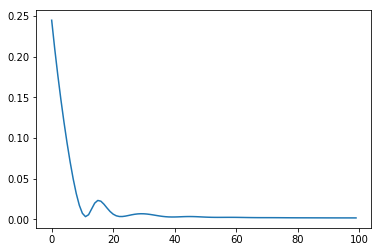

In [0]:
plt.plot(history)
# dplt.plot(history.history['val_loss'])

In [0]:
# X_train_X_test = np.concatenate((X_train, X_test),axis=0)
# hidden_state = None
rnn.eval()
# test_inputs = torch.tensor(X_test).float().cuda()
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

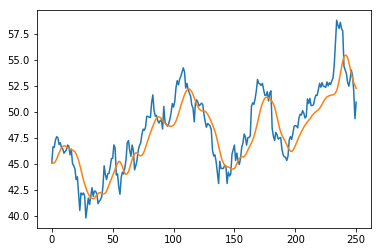

In [0]:
plt.plot(sc.inverse_transform(y_test.reshape(-1,1)))
plt.plot(sc.inverse_transform(test_predict_cpu))

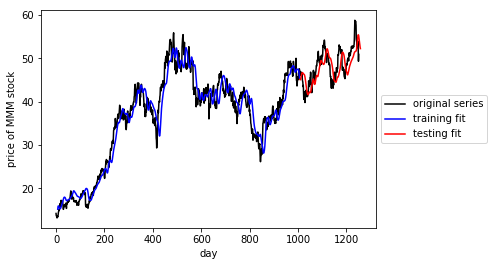

In [0]:
# plot original data
plt.plot(sc.inverse_transform(y.reshape(-1,1)), color='k')

# train_inputs = torch.tensor(X_train).float().cuda()
train_pred, hidden_state = rnn(inputs_cuda, None)
train_pred_cpu = train_pred.cpu().detach().numpy()

# use hidden state from previous training data
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

# plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
split_pt = int(X.shape[0] * 0.80) + WINDOW_SIZE # window_size
plt.plot(np.arange(WINDOW_SIZE, split_pt, 1), sc.inverse_transform(train_pred_cpu), color='b')
plt.plot(np.arange(split_pt, split_pt + len(test_predict_cpu), 1), sc.inverse_transform(test_predict_cpu), color='r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('price of MMM stock')
plt.legend(['original series','training fit','testing fit'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
